# Test rotation MNIST

In [ ]:
!pip install augly

In [1]:
import os
import dynamax
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from augly import image
from dynamax.rebayes import datasets

In [128]:
import jax
import optax
import jax.numpy as jnp
import flax.linen as nn
from functools import partial
from tqdm.notebook import tqdm
from typing import Callable, Tuple
from jaxtyping import Array, Float, Int
from flax.training.train_state import TrainState

In [2]:
%config InlineBackend.figure_format = "retina"

In [117]:
n_processes = os.cpu_count() - 2
mnist_train = torchvision.datasets.MNIST(root="./data", train=True, download=True)
images = np.array(mnist_train.data) / 255.0
labels = mnist_train.targets

mnist_test = torchvision.datasets.MNIST(root="./data", train=False)
images_test = np.array(mnist_test.data) / 255.0
labels_test = mnist_test.targets

In [118]:
def processor(X, angle):
    X_shift = image.aug_np_wrapper(X, image.rotate, degrees=angle)
    size_im = X_shift.shape[0]
    size_pad = (28 - size_im) // 2
    size_pad_mod = (28 - size_im) % 2
    X_shift = np.pad(X_shift, (size_pad, size_pad + size_pad_mod))
    
    return X_shift

In [119]:
label_target = 2
images_target = images[labels == label_target]
images_target_test= images_test[labels_test == label_target]

images_target_test.shape

(1032, 28, 28)

## Rotation

In [120]:
def generate_rotated_mnist(images, process, n_processes):
    n_configs = len(images)
    angles = np.random.uniform(0, 180, n_configs)
    configs = [{"angle": float(angle)} for angle in angles]
    images_proc = process(images, configs, n_processes=n_processes)
    return images_proc, angles

In [148]:
%%time
processer = datasets.DataAugmentationFactory(processor)

np.random.seed(314)
X_train, y_train = generate_rotated_mnist(images_target, processer, n_processes)
X_test, y_test = generate_rotated_mnist(images_target_test, processer, n_processes)

CPU times: user 0 ns, sys: 9.28 s, total: 9.28 s
Wall time: 9.9 s


In [149]:
np.random.seed(314)
n_test = 8
ixs_test = np.random.randint(0, len(X_train), size=n_test)

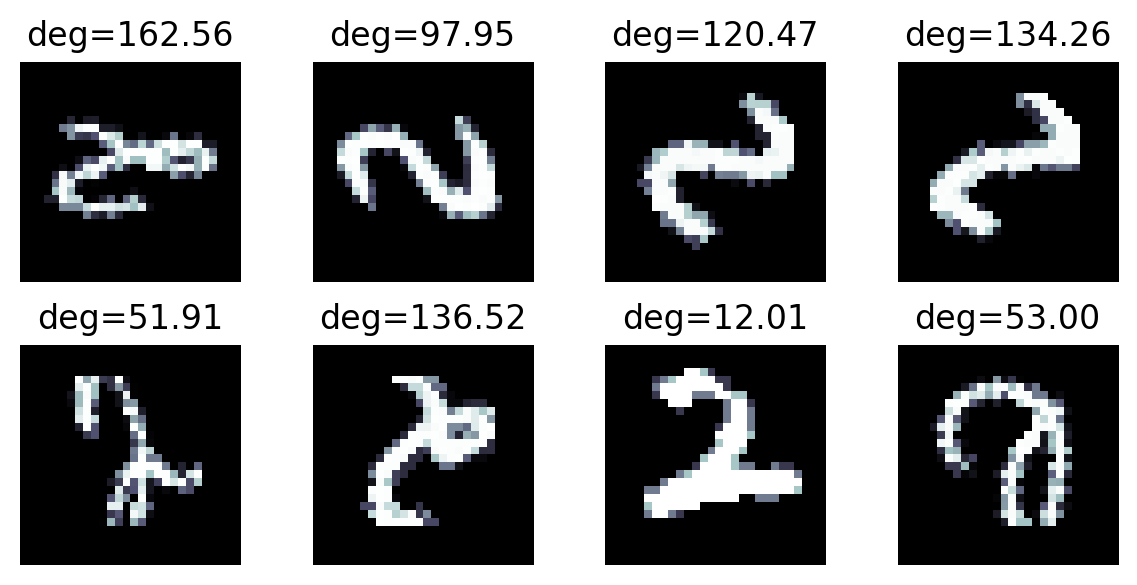

In [150]:
fig, axs = plt.subplots(2, 4, figsize=(6, 3))
axs = axs.ravel()
for ax, ix in zip(axs, ixs_test):
    img = X_train[ix]
    deg = y_train[ix]
    ax.imshow(img.reshape(28, 28), cmap="bone")
    ax.axis("off")
    ax.set_title(f"{deg=:0.2f}")
plt.tight_layout()

# Training

## Setup

In [254]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(200)(x)
        x = self.activation(x)
        x = nn.Dense(200)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x


@partial(jax.jit, static_argnames=("applyfn",))
def lossfn(params, X, y, applyfn):
    yhat = applyfn(params, X)
    mll = (y - yhat.ravel()) ** 2
    return mll.mean()


@partial(jax.jit, static_argnames=("loss_grad",))
def train_step(
    X: Float[Array, "num_obs dim_obs"],
    y: Float[Array, "num_obs"],
    ixs: Int[Array, "batch_len"],
    state: TrainState,
    loss_grad: Callable,
) -> Tuple[float, TrainState]:
    """
    Perform a single training step.
    The `loss_grad` function
    """
    X_batch = X[ixs]
    y_batch = y[ixs]
    loss, grads = loss_grad(state.params, X_batch, y_batch, state.apply_fn)    
    state = state.apply_gradients(grads=grads)
    return loss, state


loss_grad = jax.value_and_grad(lossfn, 0)

In [255]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)

In [256]:
model = MLP(1)
batch_init = jnp.ones((10, 28 ** 2))
params_init = model.init(key_init, batch_init)

In [257]:
buffer_size = 10 # Batch size
num_epochs = 500

In [258]:
X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X = jnp.array(X_train)[:100]
y = jnp.array(y_train)[:100]

ix_sort = jnp.argsort(y)
X = X[ix_sort]
y = y[ix_sort]

## Vanilla SGD

In [259]:
@partial(jax.jit, static_argnums=(1,2))
def get_batch_train_ixs(key, num_samples, batch_size):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation.
    """
    steps_per_epoch = num_samples // batch_size
    
    batch_ixs = jax.random.permutation(key, num_samples)
    batch_ixs = batch_ixs[:steps_per_epoch * batch_size]
    batch_ixs = batch_ixs.reshape(steps_per_epoch, batch_size)
    
    return batch_ixs


def train_epoch(
    key: int,
    batch_size: int,
    state: TrainState,
    X: Float[Array, "num_obs dim_obs"],
    y: Float[Array, "num_obs"],
    loss_grad: Callable,
):
    num_train = X.shape[0]
    loss_epoch = 0.0
    train_ixs = get_batch_train_ixs(key, num_train, batch_size)
    for ixs in train_ixs:
        loss, state = train_step(X, y, ixs, state, loss_grad)
        loss_epoch += loss
    return loss_epoch, state

In [260]:
keys_train = jax.random.split(key_train, num_epochs)

In [261]:
state = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(1e-4)
)

losses = []
crossval = []

elements  = list(enumerate(keys_train))
pbar = tqdm(elements)
for (e, key) in pbar:
    loss, state, = train_epoch(key, buffer_size, state, X, y, loss_grad)
    losses.append(loss)
    
    xv_test = lossfn(state.params, X_test, y_test, state.apply_fn)
    crossval.append(xv_test)

    losstr = f"{loss:0.4e}"
    pbar.set_description(losstr)

  0%|          | 0/500 [00:00<?, ?it/s]

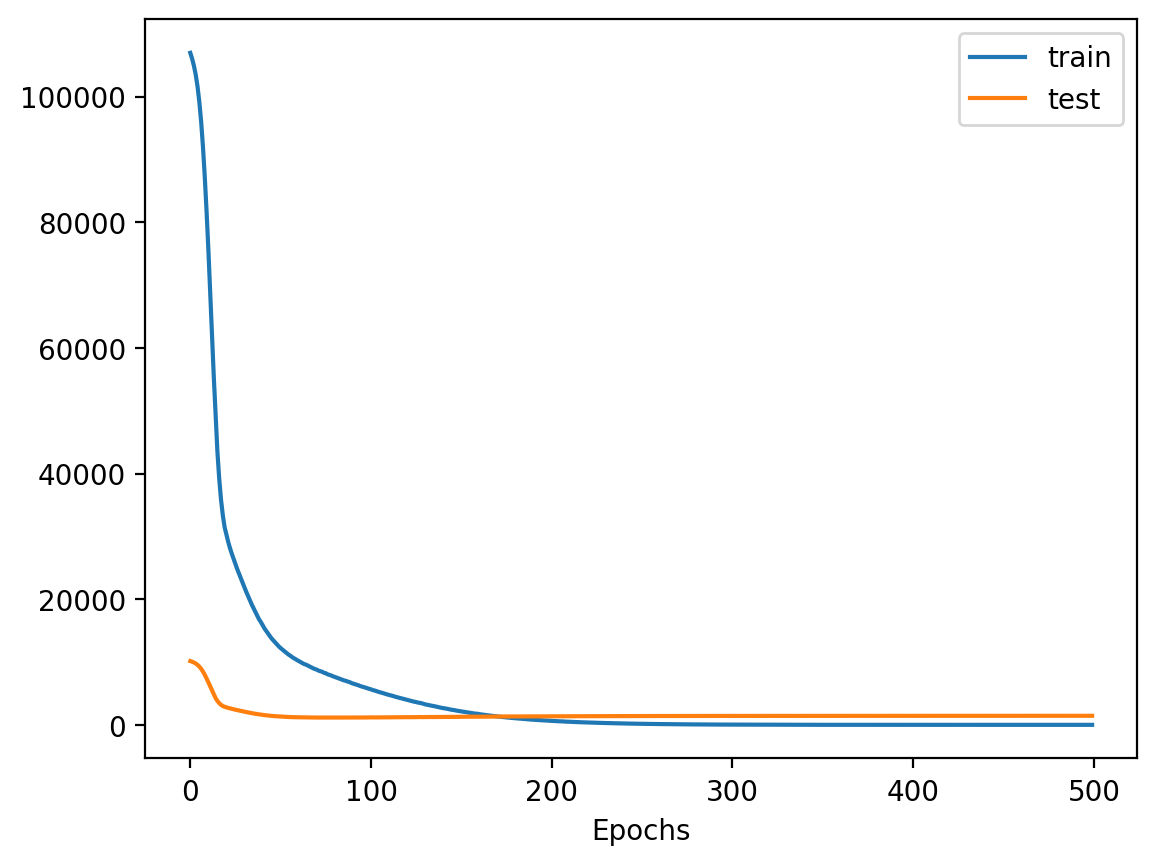

In [262]:
plt.plot(losses, label="train")
plt.plot(crossval, label="test")
plt.legend()
plt.xlabel("Epochs");

## Replay buffer FIFO

Consider a buffer with size 4, the minibatches are given by
```
[x0, x1, x2, x3]
[x1, x2, x3, x4]
[x2, x3, x4, x5]
[x3, x4, x5, x6]
...
```

In [263]:
def fifo_batches(ix, num_train, buffer_size):
    ix_lookback = (ix - buffer_size) - 1
    batches = jnp.arange(ix_lookback, ix) + 1
    return batches

In [264]:
fifo_batches(2, 100, 10)

DeviceArray([-8, -7, -6, -5, -4, -3, -2, -1,  0,  1,  2], dtype=int32)

In [265]:
num_train = 100

In [266]:
state = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(1e-4)
)

losses = []
crossval = []

elements  = range(num_train)
pbar = tqdm(elements)
for ix in pbar:
    
    ixs = fifo_batches(ix, num_train, buffer_size)
    ixs = ixs[ixs >= 0]
    # Add inner for-loop
    for _ in range(10):
        loss, state = train_step(X, y, ixs, state, loss_grad)
    losses.append(loss)
    
    xv_test = lossfn(state.params, X_test, y_test, state.apply_fn)
    crossval.append(xv_test)

    losstr = f"{loss:0.4e}"
    pbar.set_description(losstr)

  0%|          | 0/100 [00:00<?, ?it/s]

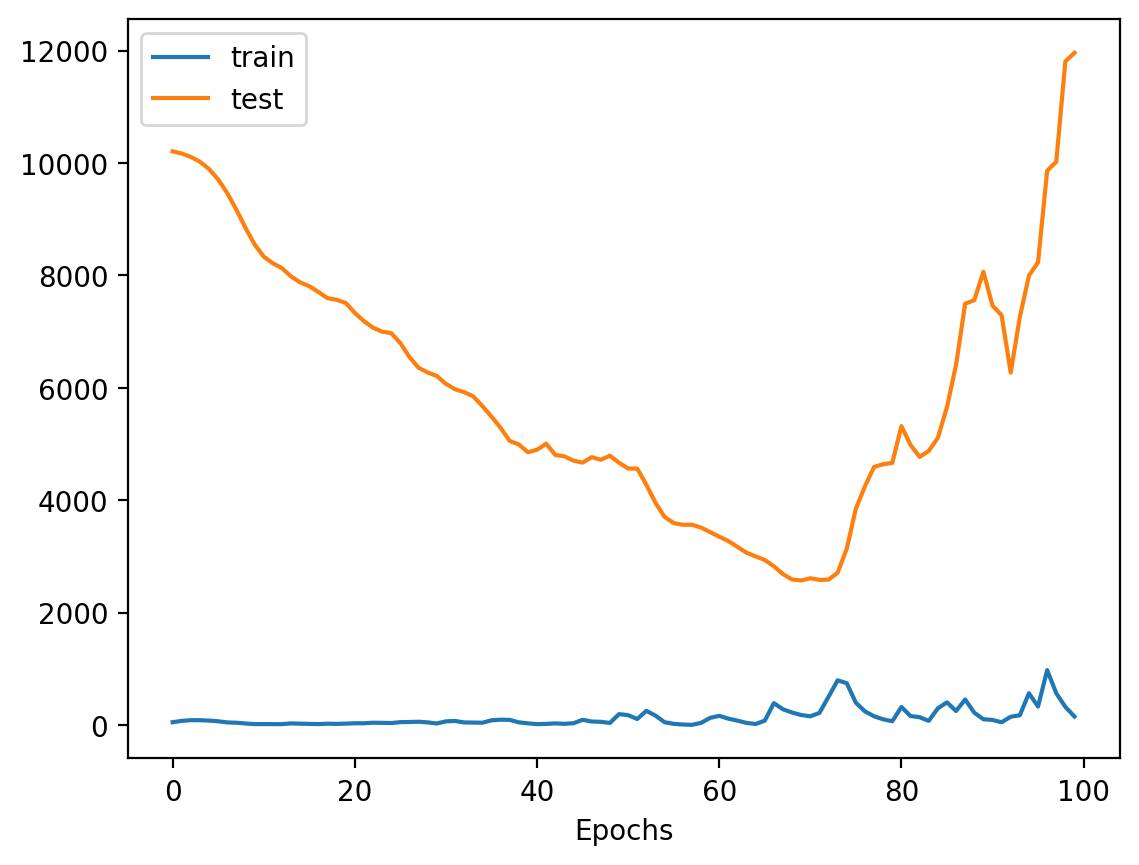

In [267]:
plt.plot(losses, label="train")
plt.plot(crossval, label="test")
plt.legend()
plt.xlabel("Epochs");